# 20기 Clustering 정규세션 과제

**데이터:** [Mall Customer Segmentation Data| Kaggle](https://www.kaggle.com/vjchoudhary7/customer-segmentation-tutorial-in-python)

---

## 0. 데이터 불러오기

In [1]:
import warnings
warnings.filterwarnings("ignore") 

In [2]:
import pandas as pd
df = pd.read_csv("Mall_Customers.csv", index_col = 0)
df.head()

,Gender,Age,Annual Income (k$),Spending Score (1-100)
CustomerID,,,,
1,Male,19,15,39
2,Male,21,15,81
3,Female,20,16,6
4,Female,23,16,77
5,Female,31,17,40


## 1. Preprocssing / EDA

In [3]:
df.isna().sum()

Gender                    0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64

In [5]:
numerical_features = [col for col in df.columns if df[col].dtypes != 'O']
discrete_features = [col for col in numerical_features if len(df[col].unique()) < 10 and col not in ['CustomerID']]
continuous_features = [feature for feature in numerical_features if feature not in discrete_features+['CustomerID']]
categorical_features = [col for col in df.columns if df[col].dtype == 'O']

print("No of continuous features are : ", len(continuous_features))
print("Number of categorical features : ",len(categorical_features))

No of continuous features are :  3
Number of categorical features :  1


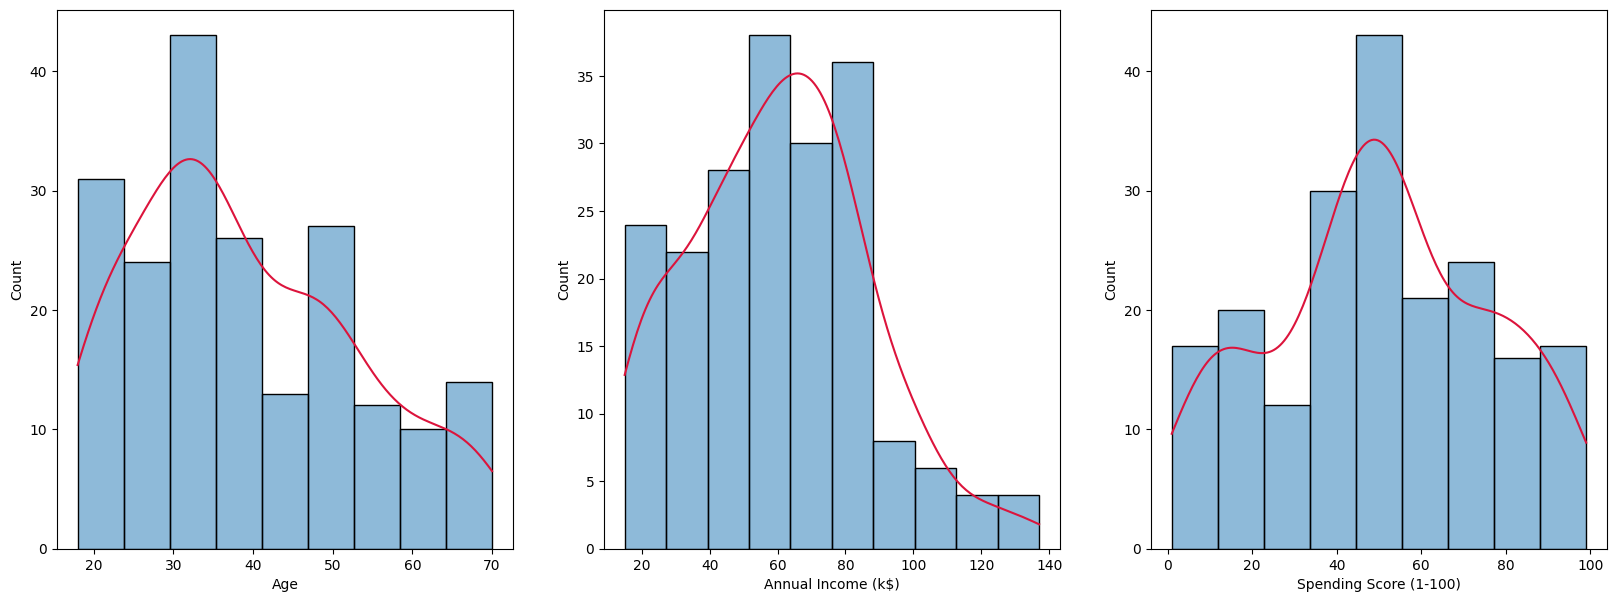

In [6]:
# Check Distribution - Continuous
import matplotlib.pyplot as plt
import seaborn as sns

f, axes = plt.subplots(2,2 , figsize=(20, 7), sharex=False)
pos = 1
for i, feature in enumerate(continuous_features):

  plt.subplot(1 , 3 , pos)
  ax = sns.histplot(data=df, x = feature,kde=True,palette="husl") # ax=axes[i%2, i//2]
  ax.lines[0].set_color('crimson')
  pos = pos + 1

In [8]:
# Encoding Categorical Features
df = pd.get_dummies(df).reset_index(drop=True)

## 2. Clustering

### Clustering method

1) Hierarchical clustering (계층적 군집화)
- 개체들을 가까운 집단부터 차근차근 묶어가는 방식
- 군집화 결과 뿐만 아니라 유사한 개체들이 결합되는 절차까지
- 예시 : Agglomerative

2) Partitioning clustering (비계층적 군집화)
- 전체 데이터의 영역을 특정 기준에 의해 동시에 구분 
- 예시 : K-Means / DBSCAN

+) 최적의 군집 수 결정 : Elbow point 이용

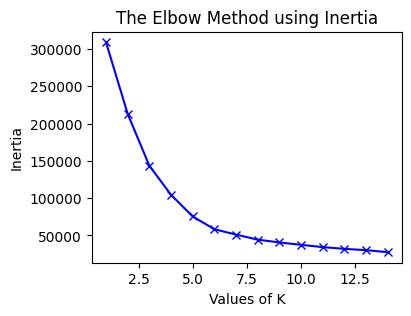

In [46]:
# Elbow Method
inertia = []
range_val = range(1,15)
for i in range_val:
  kmean = KMeans(n_clusters=i)
  kmean.fit_predict(pd.DataFrame(df))
  inertia.append(kmean.inertia_)
plt.figure(figsize=(4,3))
plt.plot(range_val,inertia,'bx-')
plt.xlabel('Values of K') 
plt.ylabel('Inertia') 
plt.title('The Elbow Method using Inertia') 
plt.show()

* From the above elbow method we see that K = 5 is the best K value for our clustering

In [10]:
# clustering algorithms
from sklearn.cluster import KMeans,AgglomerativeClustering,DBSCAN

In [18]:
# Agglomerative Clustering
agglo_model = AgglomerativeClustering(linkage="ward",n_clusters=5)
agglomerative_clusters = agglo_model.fit_predict(df)

In [19]:
# K-Means Clustering
kmeans_model=KMeans(5)
kmeans_clusters = kmeans_model.fit_predict(df)

In [15]:
# DBSCAN Clustering
model_dbscan = DBSCAN(eps=3, min_samples=17)
dbscan_clusters = model_dbscan.fit_predict(df)

### To compare which clustering algorithm is best for our model

1) Dunn Index
2) Silhouette Index

In [40]:
from sklearn.metrics import silhouette_score
import numpy as np

def silhouette_method(df, algorithm, y_pred):
    try:
        assert isinstance(df, pd.DataFrame), "Input 'df' should be a pandas DataFrame."
        assert isinstance(y_pred, (np.ndarray, list)), "Input 'y_pred' should be an array-like object."

        score = silhouette_score(df, y_pred)
        print(f"{algorithm} silhouette score: {score:.4f}")

    except AssertionError as e:
        print(f"Error: {e}")

silhouette_method(df, 'K-Means', kmeans_clusters)
silhouette_method(df, 'Agglomerative', agglomerative_clusters)

def silhouette_method_dbscan(df, dbscan_labels):
    try:
        assert isinstance(df, pd.DataFrame), "Input 'df' should be a pandas DataFrame."
        assert isinstance(dbscan_labels, (np.ndarray, list)), "Input 'dbscan_labels' should be an array-like object."

        unique_labels = np.unique(dbscan_labels)
        if -1 in unique_labels:
            unique_labels = unique_labels[unique_labels != -1]  # Exclude noise points

        if len(unique_labels) > 1:
            score = silhouette_score(df, dbscan_labels)
            print(f"DBSCAN silhouette score (excluding noise): {score:.4f}")
        else:
            if len(unique_labels) == 1:
                print("DBSCAN generated only one cluster (excluding noise).")
            else:
                print("DBSCAN did not generate any clusters (excluding noise).")

    except AssertionError as e:
        print(f"Error: {e}")

silhouette_method_dbscan(df, dbscan_clusters)

K-Means silhouette score: 0.4438
Agglomerative silhouette score: 0.4398
DBSCAN did not generate any clusters (excluding noise).


* DBSCAN이 클러스터를 생성하지 않았으므로 데이터가 너무 분산되어 있거나 클러스터 간의 밀도 차이가 충분하지 않음을 파악할 수 있습니다. 따라서 위 분석 결과를 해석하면 K-Means가 다른 알고리즘과 비교하여 높은 실루엣 지수를 가지고 있다는 것을 알 수 있습니다. 높은 실루엣 지수는 클러스터링이 각 데이터 포인트를 자신의 클러스터에 잘 할당하고 있으며, 클러스터들 간에도 상대적으로 잘 분리되어 있음을 나타냅니다. 즉, K-Means 알고리즘이 다른 알고리즘보다 더 효과적으로 데이터를 그룹으로 나누어 클러스터링하고 있다는 결론을 내릴 수 있습니다. 

## 3. Evaluation

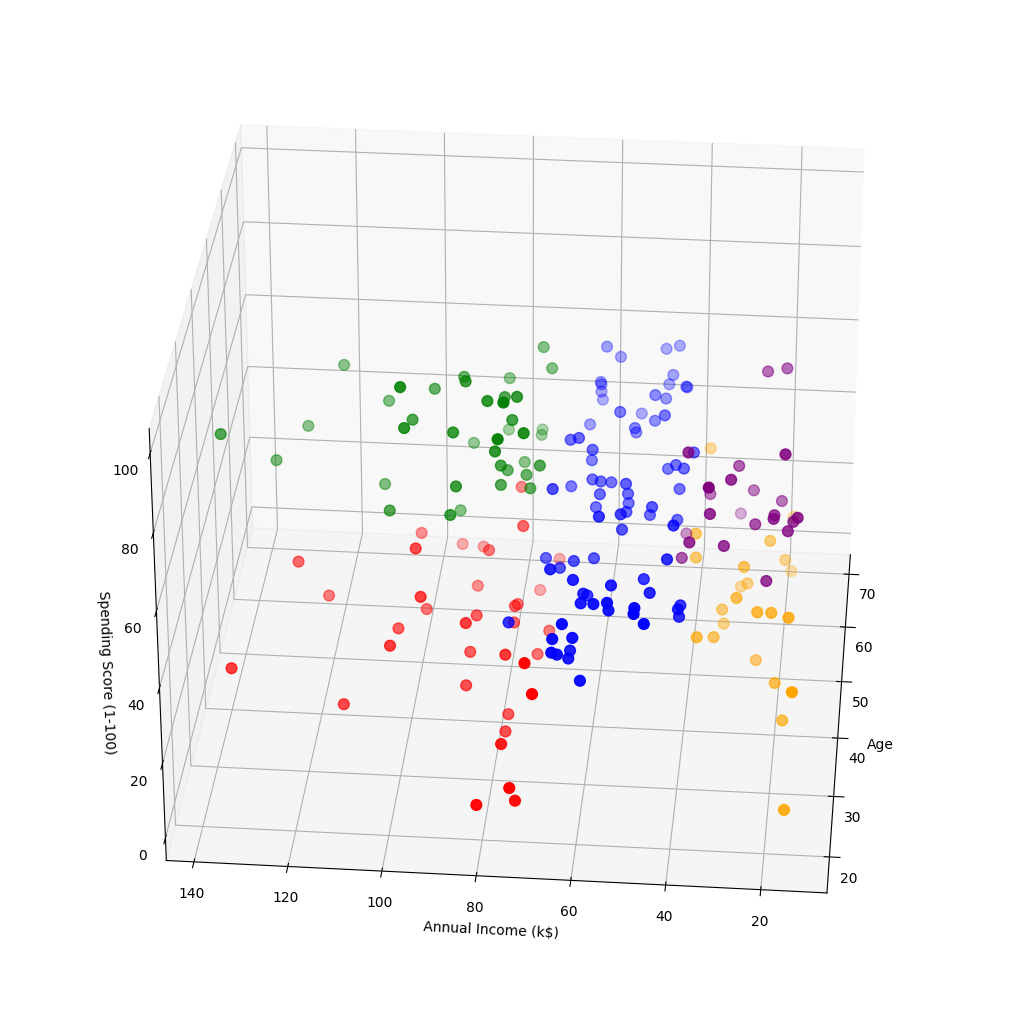

In [48]:
# Cluster Visualization
from mpl_toolkits.mplot3d import Axes3D

df["label"] = kmeans_clusters

fig = plt.figure(figsize=(20,13))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df.Age[df.label == 0], df["Annual Income (k$)"][df.label == 0], df["Spending Score (1-100)"][df.label == 0], c='blue', s=60)
ax.scatter(df.Age[df.label == 1], df["Annual Income (k$)"][df.label == 1], df["Spending Score (1-100)"][df.label == 1], c='red', s=60)
ax.scatter(df.Age[df.label == 2], df["Annual Income (k$)"][df.label == 2], df["Spending Score (1-100)"][df.label == 2], c='green', s=60)
ax.scatter(df.Age[df.label == 3], df["Annual Income (k$)"][df.label == 3], df["Spending Score (1-100)"][df.label == 3], c='orange', s=60)
ax.scatter(df.Age[df.label == 4], df["Annual Income (k$)"][df.label == 4], df["Spending Score (1-100)"][df.label == 4], c='purple', s=60)
ax.view_init(30, 185)
plt.xlabel("Age")
plt.ylabel("Annual Income (k$)")
ax.set_zlabel('Spending Score (1-100)')
plt.show()